# TensorFlow Tutorial - Part 3

This code is provided as supplementary material of the lecture Machine Learning and Optimization in Communications (MLOC).<br>

This code illustrates
* Example of analyzing models in Tensorboard 

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline

Generate data coming from a simple polynomial and corrupt with noise

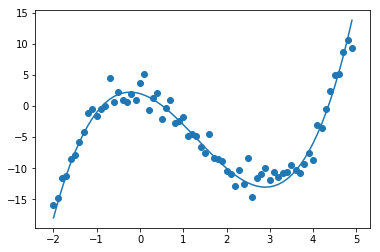

In [2]:
x = np.arange(-2, 5, 0.1)
y = x**3 - 4*x**2 - 2*x + 2
y_noise = y + np.random.normal(0, 1.5, size=(len(x),))
plt.close("all")
plt.plot(x, y)
plt.scatter(x, y_noise);

In [3]:
# simple function to get a random mini-batch
def get_batch(x, y, batch_size=20):
    idxs = np.random.randint(0, len(x), (batch_size))
    return x[idxs], y[idxs]

Attach summarizes to a variable using the following helper function. This is useful for visualizing inside Tensorboard afterwards

In [4]:
def helper_variable_summaries(var):
    """Attach a lot of summaries to a Tensor (for TensorBoard visualization)."""
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean)
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
            tf.summary.scalar('stddev', stddev)
            tf.summary.scalar('max', tf.reduce_max(var))
            tf.summary.scalar('min', tf.reduce_min(var))
            tf.summary.histogram('histogram', var)

Define graph by model, use 2 hidden layers, one with ReLU and the other one with tanh activation (overkill for this example, but for illustration purposes).

We introduce a new type of TensorFlow variables, the ones that can be trained. These belong to `tf.Variable`

In [5]:
mini_batch_size = 10

neurons_H1 = 4
neurons_H2 = 5

input_x = tf.placeholder(tf.float32, shape=(mini_batch_size),  name='input_x')
input_y = tf.placeholder(tf.float32, shape=(mini_batch_size),  name='input_y')

tf_x = tf.constant(x, dtype=tf.float32, name='x_range')

# tf.truncated_normal is the initializer of the variable
# specify the variables of our model
with tf.name_scope('Hidden_Layer_1'):
    with tf.name_scope('w1'):
        w1 = tf.Variable(tf.truncated_normal([1,neurons_H1], stddev=0.8), name='W1')
        helper_variable_summaries(w1)
    with tf.name_scope('b1'):
        b1 = tf.Variable(tf.truncated_normal([neurons_H1], stddev=0.8), name='b1')
        helper_variable_summaries(b1)

with tf.name_scope('Hidden_Layer_2'):
    with tf.name_scope('W2'):
        W2 = tf.Variable(tf.truncated_normal([neurons_H1, neurons_H2], stddev=0.8), name='W2')
        helper_variable_summaries(W2)
    with tf.name_scope('b2'):
        b2 = tf.Variable(tf.truncated_normal([neurons_H2], stddev=0.8), name='b2')
        helper_variable_summaries(b2)
    
with tf.name_scope('Output_Layer'):
    with tf.name_scope('w3'):
        w3 = tf.Variable(tf.truncated_normal([neurons_H2,1], stddev=0.8), name='w3')
        helper_variable_summaries(w3)

# build graph
with tf.name_scope('Neural_Network'):
    nn = tf.expand_dims(input_x, 1)
    nn = tf.nn.tanh(tf.matmul(nn, w1)+b1, name='Tanh_H1')
    nn = tf.nn.tanh(tf.matmul(nn, W2)+b2, name='Tanh_H2')
    output = tf.squeeze(tf.matmul(nn,w3)) # squeeze removes the excess dimensions    

    
with tf.name_scope('Loss'):
    loss = tf.reduce_mean(tf.pow(output-input_y,2), name='Loss')
    tf.summary.scalar('loss',loss)
    
optimizer = tf.train.AdamOptimizer(name='Optimizer').minimize(loss)

# build side graph that generates the output from y
with tf.name_scope('hidden'):
    nn = tf.expand_dims(tf_x, 1)
    nn = tf.nn.tanh(tf.matmul(nn, w1)+b1, name='Tanh_H1_eval')
    nn = tf.nn.tanh(tf.matmul(nn, W2)+b2, name='Tanh_H2_eval')
    y_est = tf.squeeze(tf.matmul(nn,w3))

merged = tf.summary.merge_all()

Instructions for updating:
Colocations handled automatically by placer.


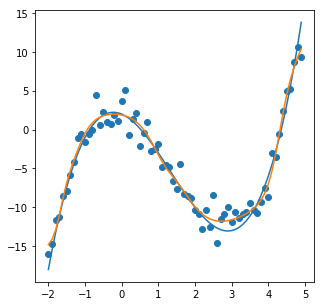

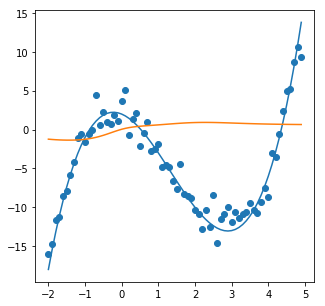

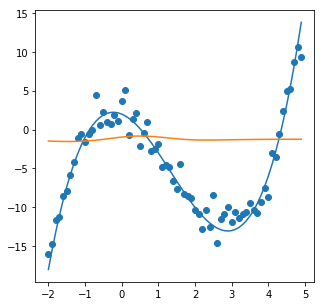

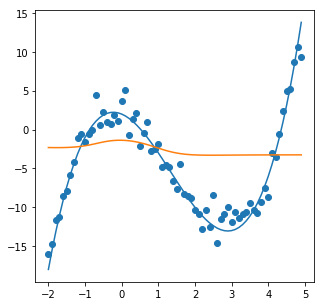

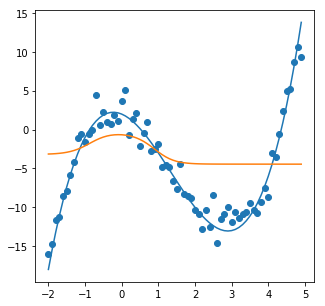

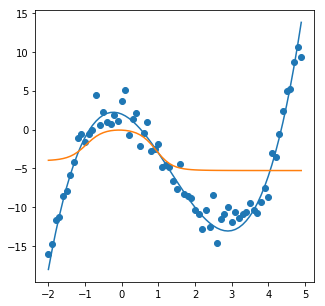

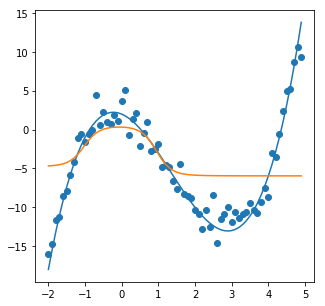

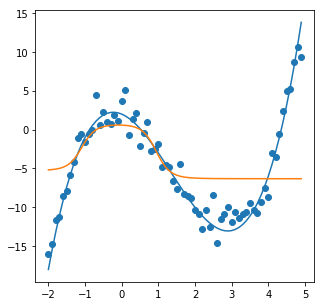

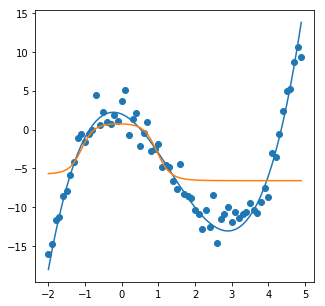

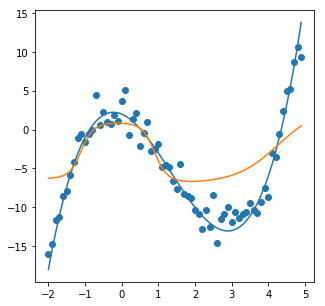

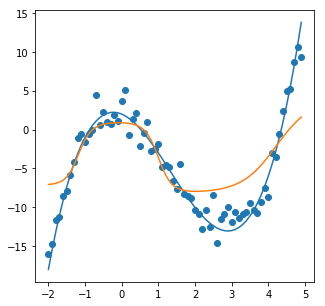

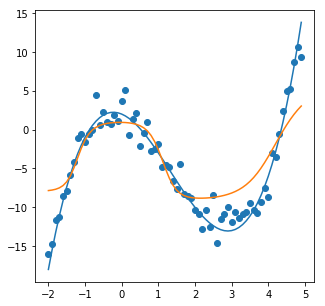

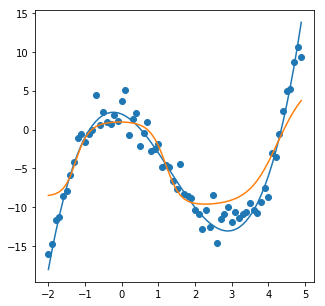

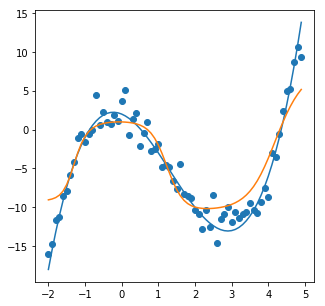

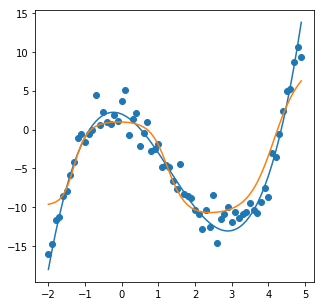

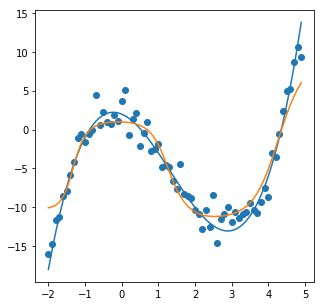

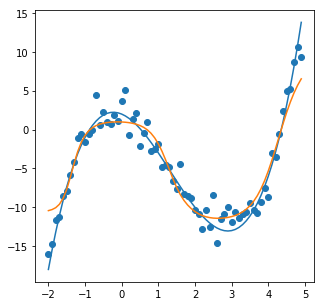

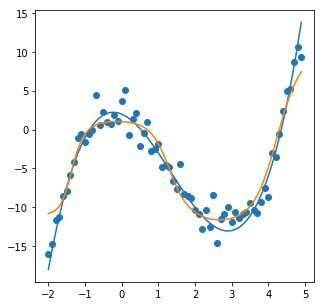

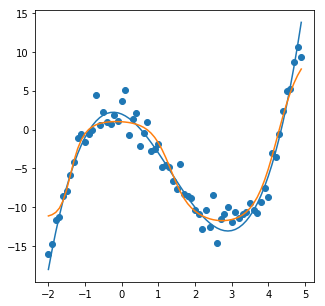

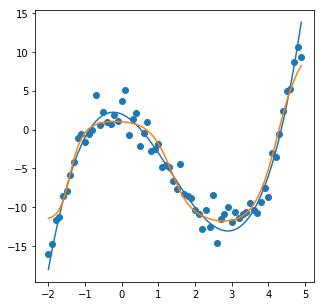

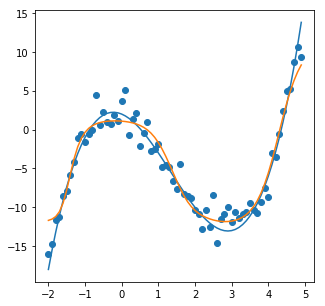

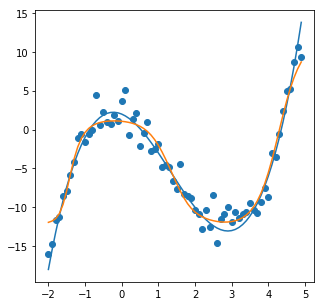

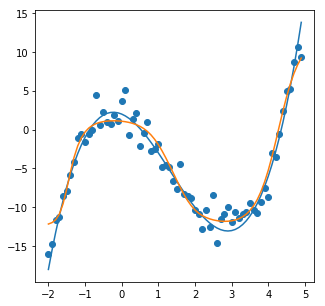

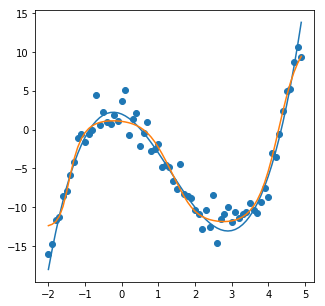

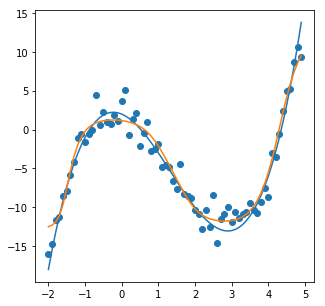

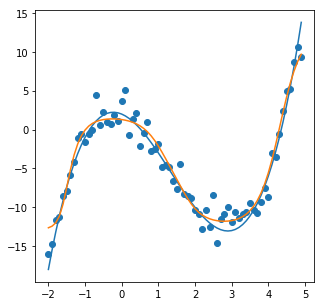

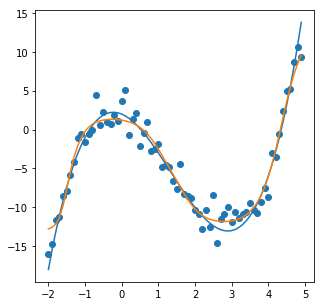

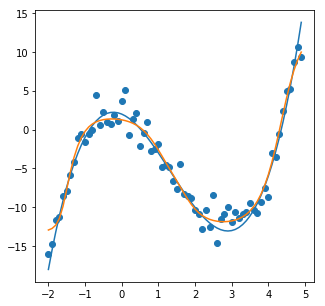

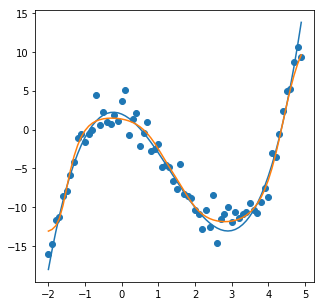

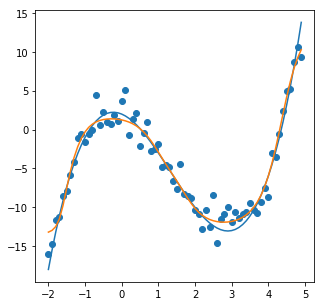

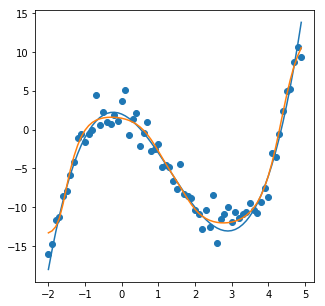

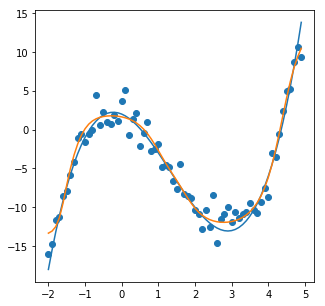

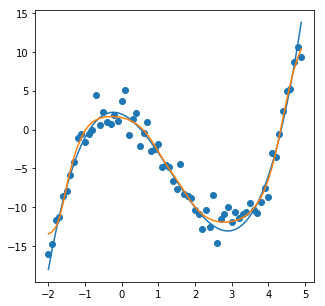

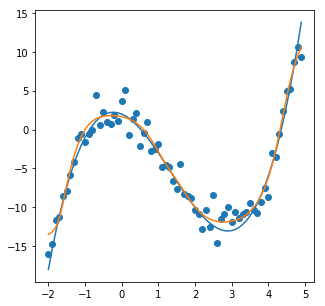

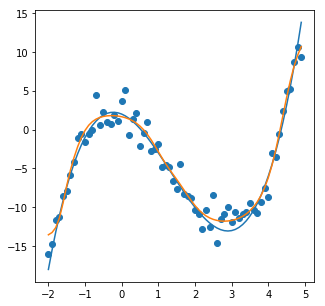

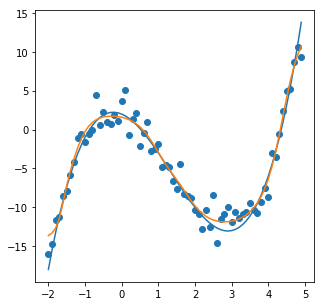

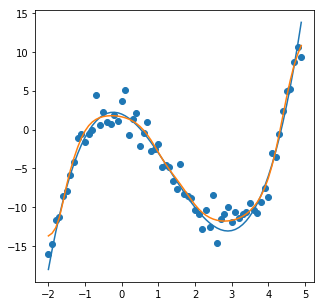

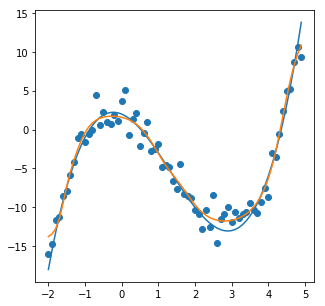

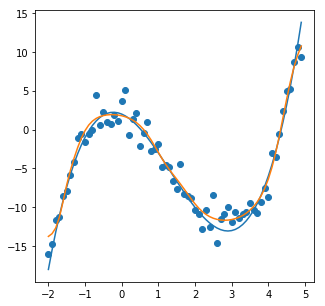

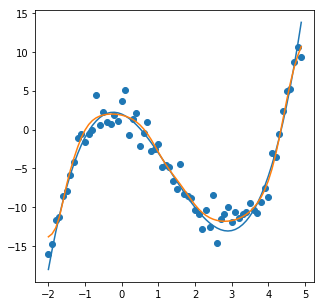

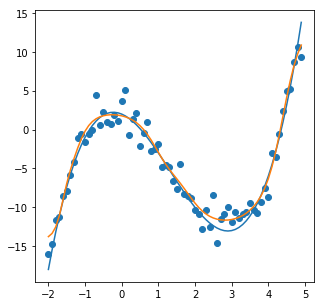

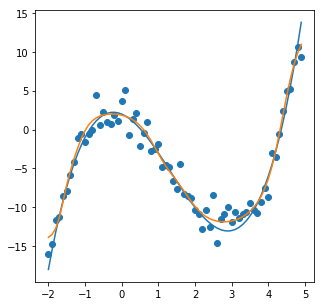

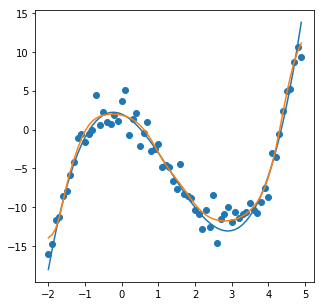

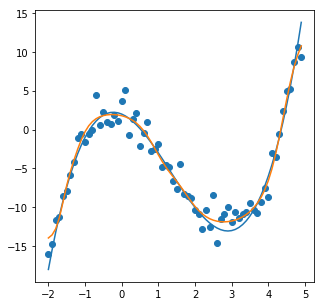

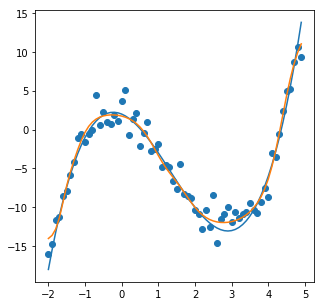

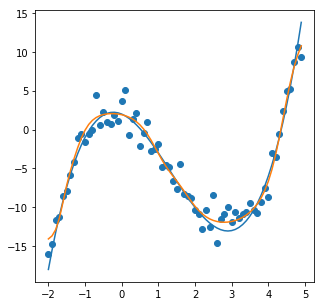

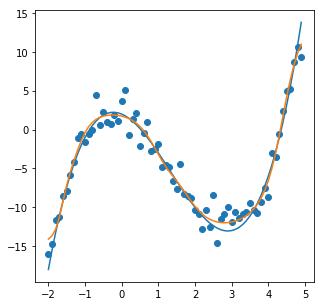

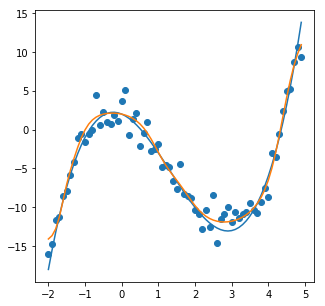

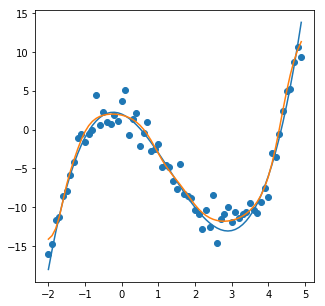

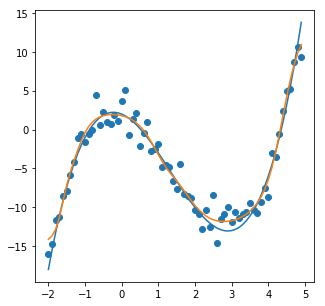

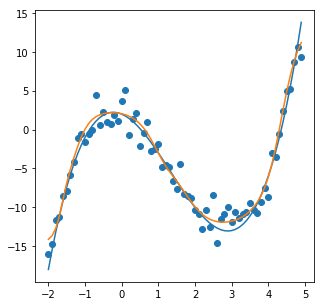

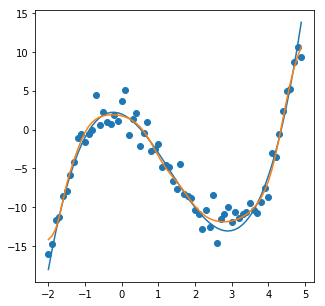

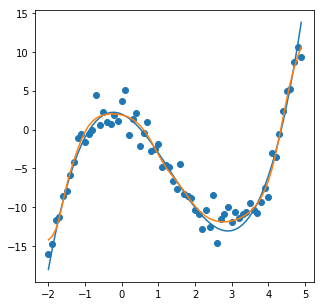

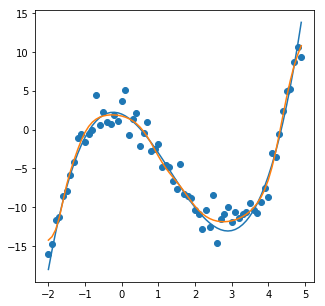

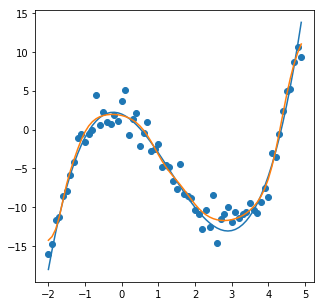

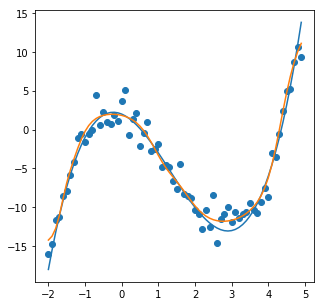

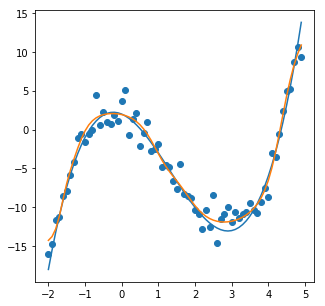

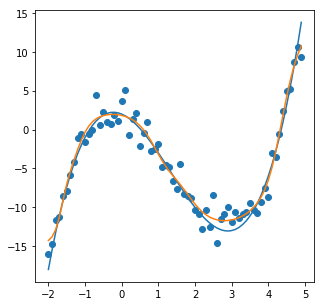

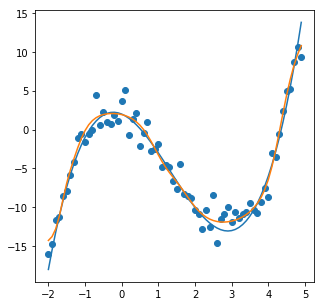

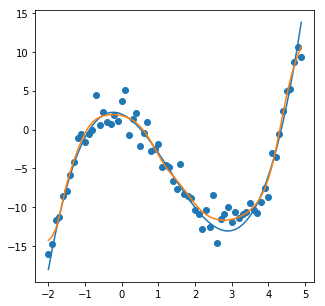

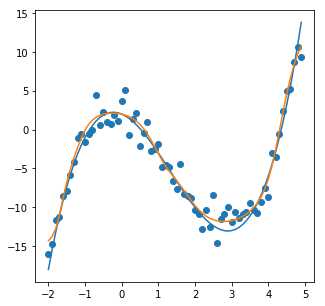

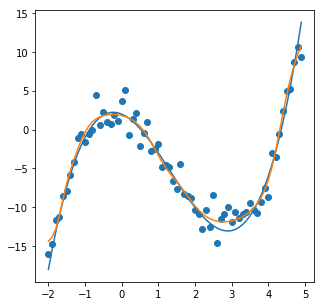

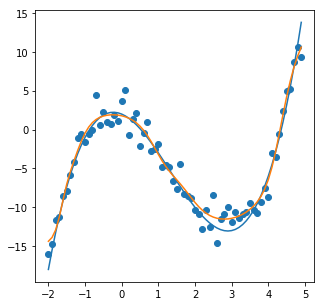

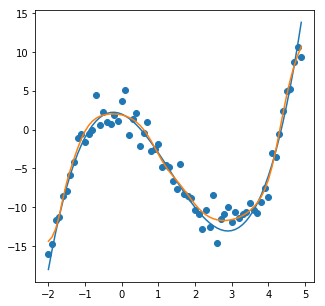

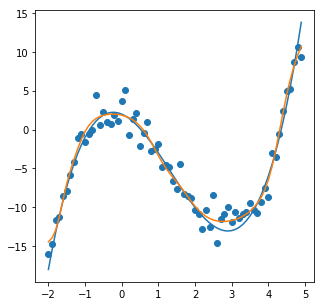

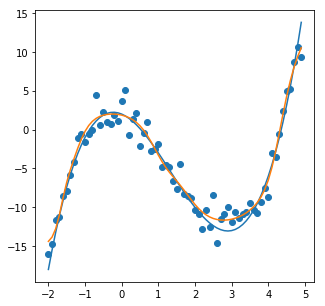

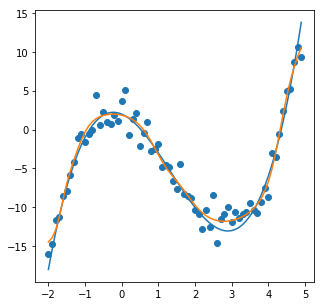

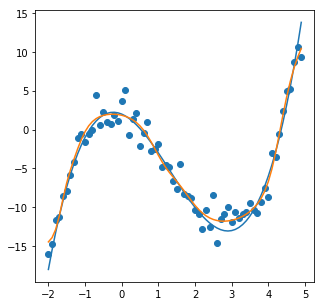

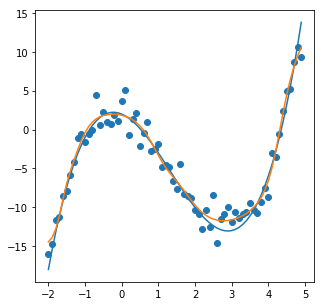

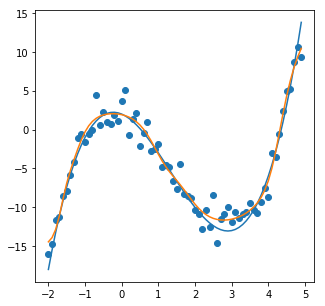

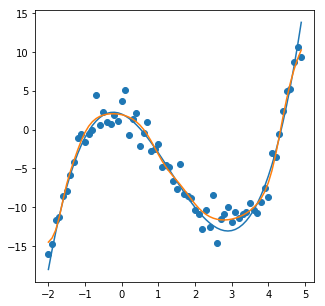

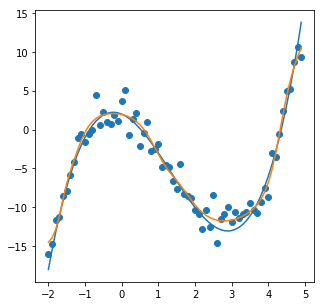

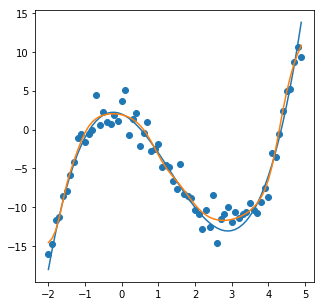

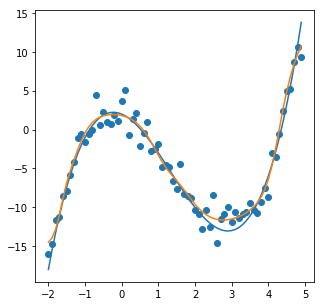

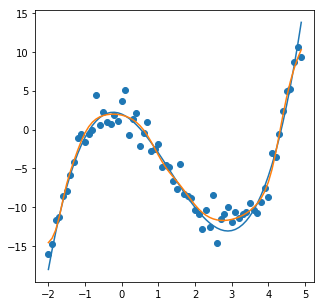

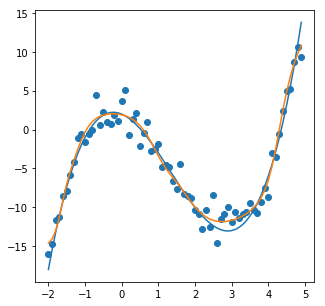

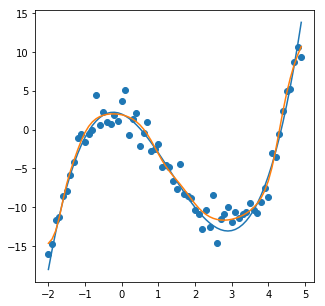

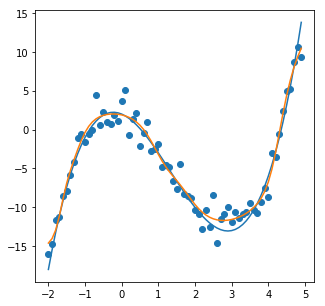

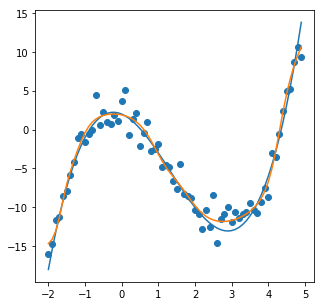

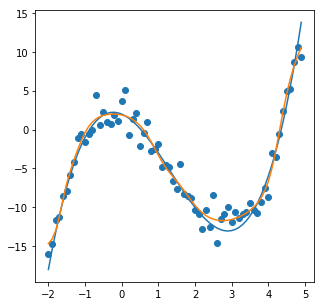

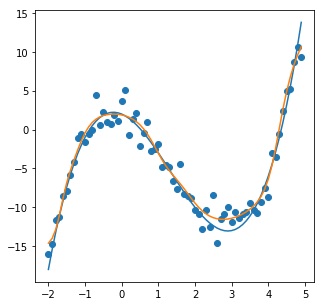

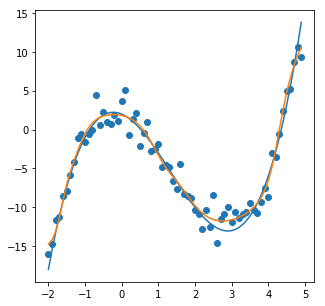

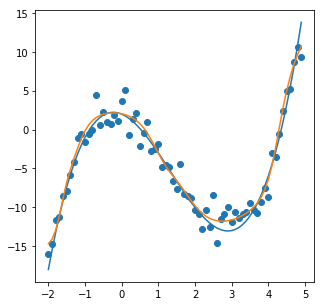

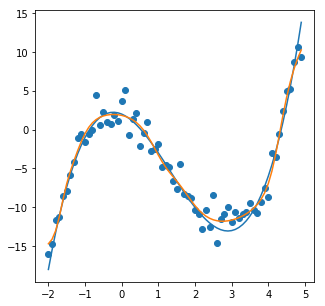

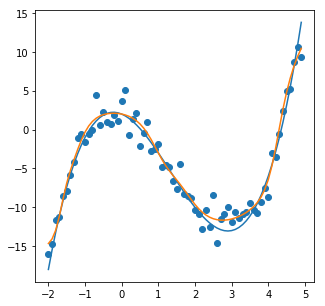

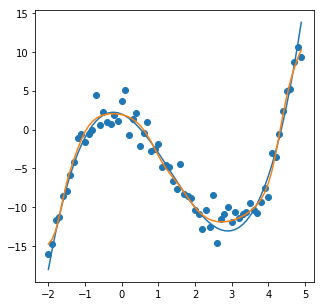

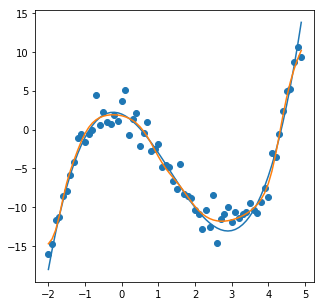

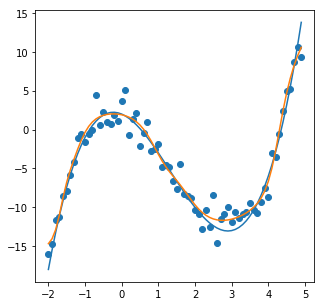

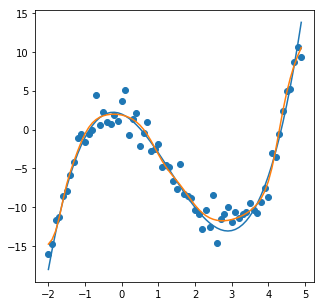

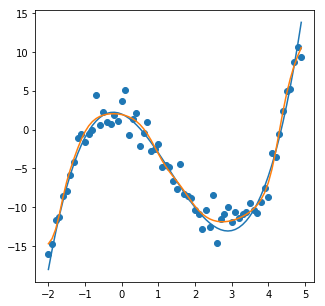

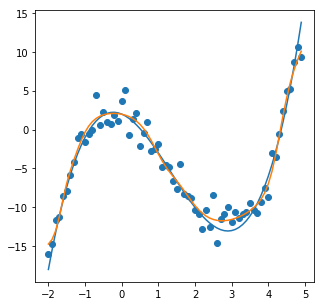

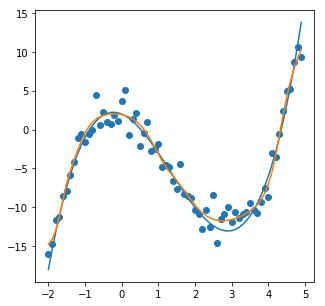

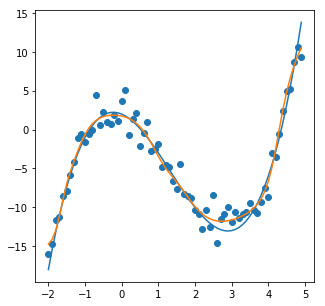

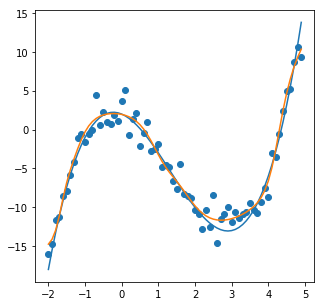

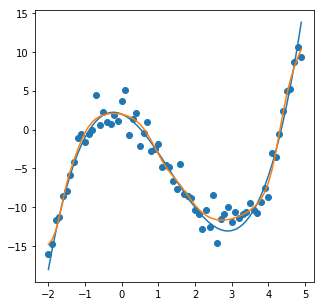

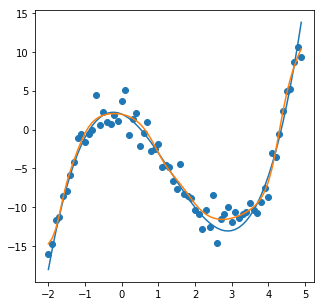

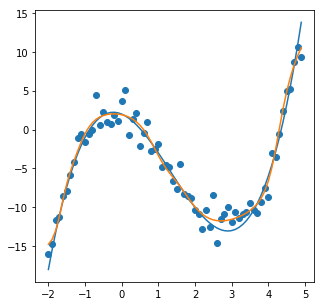

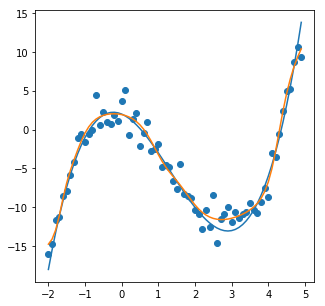

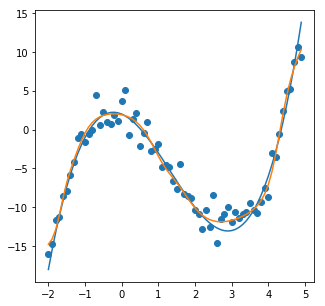

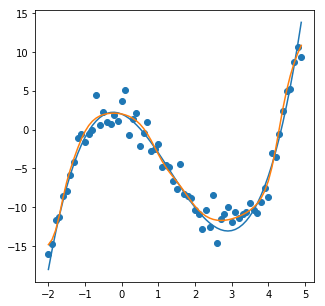

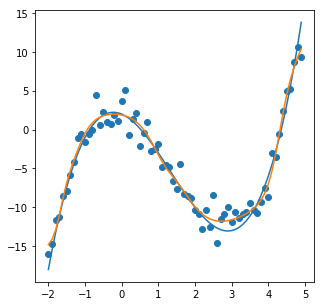

In [6]:
num_iter = 100*300
image_cycle = 300

with tf.Session() as session:
    # initialize variables
    train_writer = tf.summary.FileWriter('./logs', tf.get_default_graph())
    
    tf.global_variables_initializer().run()

    print('Initialized')
    for step in range(num_iter):    
        batch_x, batch_y = get_batch(x,y_noise, mini_batch_size)
        feed_dict = {input_x : batch_x, input_y : batch_y}
        summary,_ = session.run([merged,optimizer], feed_dict=feed_dict)
        
        if step % 10 == 0:
            train_writer.add_summary(summary, step)

        # plot result of learning
        if step % image_cycle == 0:
            fig,ax = plt.subplots(1,1,figsize=(5,5))        
            plt.scatter(x, y_noise)
            plt.plot(x, y)
            plt.plot(x, y_est.eval())
            display.clear_output(wait=True)
            display.display(plt.gcf())
            
train_writer.close()

Now start tensorboard from the command line with `tensorboard --logdir ./logs` from the directory (and the anaconda environment) the notebook is in and load the log file